# Simulation of an epidemic model

### Markov model :
* $(x,y) \rightarrow (x+1,y)$ at rate $\mu x$ (births of susceptibles);
* $(x,y) \rightarrow (x-1,y+1)$ at rate $\beta x y$ (infections);
* $(x,y) \rightarrow (x,y-1)$ at rate $\gamma y$ (death of infections);

### Lotka--Volterra model associated 
First order deterministic approximation:
\begin{align}
  d x_t = \mu x_t - \beta x_t y_t \\
  d y_t = \beta x_t y_t -\gamma y_t.
\end{align}

Fix point :
\begin{equation}
  x_{\star} = \gamma / \beta \quad y_{\star} = \mu / \beta. 
\end{equation}

Conserve quantity:
\begin{equation}
  \beta(x+y) - \gamma \log(x) - \mu\log(y).
\end{equation}

In [52]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
import matplotlib.mlab as mlab

import math

matplotlib.pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [73]:
# Scaling 
N = 10000
# Model parameters
mu = 0.1
beta = 1
gamma = 1
# Fix point
xstar = gamma / beta
ystar = mu / beta

In [83]:
# Plotting grid
xdelta = xstar * 0.01
ydelta = ystar * 0.01
xmax = xstar * 5
ymax = ystar * 5
x = np.arange(xdelta, xmax, xdelta)
y = np.arange(ydelta, ymax, ydelta)
X, Y = np.meshgrid(x, y)

In [84]:
# Compute conserve quantity
def f_cons_qty(x, y):
    return beta * (x+y) - gamma*math.log(x) - mu*math.log(y)
vf_cons_qty = np.vectorize(f_cons_qty)
cons_qty = vf_cons_qty(X, Y)

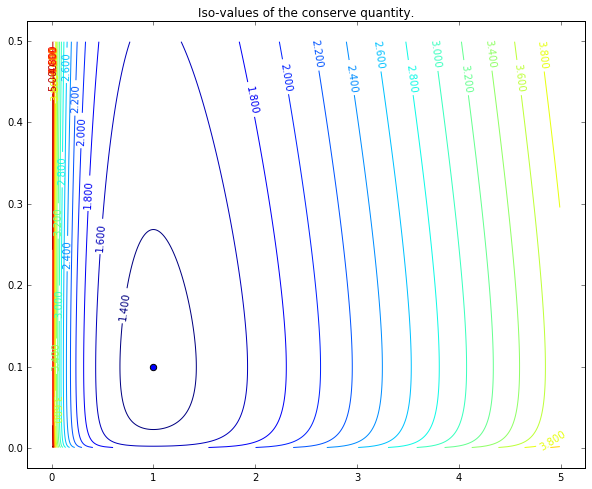

In [85]:
# Plot conserve quantity of the Lotka--Volterra model
nlines = 20
plt.figure()

# line_colours = ('BlueViolet', 'Crimson', 'ForestGreen', 'Indigo', 'Tomato', 'Maroon')
# line_widths = (1, 1.5, 2, 2.5, 3, 3.5)
cs_cons_qty = plt.contour(X, Y, cons_qty, nlines)
plt.clabel(cs_cons_qty, inline=1, fontsize=10)
plt.title('Iso-values of the conserve quantity.')
plt.scatter(xstar, ystar, marker='o', c='b', s=40)

plt.show()